First we need to import X_dataset.csv and provide labels to the dataset

In [3]:
import pyspark
import pandas as pd
import matplotlib.pyplot as plt

headers = ['class', 'largestSpot', 'spotDistribution', 'activity', 'evolution', 'previousActivity', 'complex',
           'complexOnPath', 'area', 'largestSpotArea', 'c-class', 'm-class', 'x-class']

df = pd.read_csv('SolarFlare_Clean.csv', header=None, names=headers)

df.head()

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,largestSpotArea,c-class,m-class,x-class
0,H,A,X,1,3,1,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,1,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0
3,H,R,X,1,2,1,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,1,0,0,0


From this point we will do Data Transformation to convert values to floating point numbers

In [4]:
# Class: (A,B,C,D,E,F,H) (0,1,2,3,4,5,6)
class_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'H': 6, }
df['class'] = df['class'].map(class_map)

# Largest Spot: (X,R,S,A,H,K) (0,1,2,3,4,5)
largest_spot_map = {'X': 0, 'R': 1, 'S': 2, 'A': 3, 'H': 4, 'K': 5}
df['largestSpot'] = df['largestSpot'].map(largest_spot_map)

# Spot Distribution: (X,O,I,C) (0,1,2,3)
spot_distribution_map = {'X': 0, 'O': 1, 'I': 2, 'C': 3}
df['spotDistribution'] = df['spotDistribution'].map(spot_distribution_map)

df.head()


,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,largestSpotArea,c-class,m-class,x-class
0,6,3,0,1,3,1,1,1,1,1,0,0,0
1,3,1,1,1,3,1,1,2,1,1,0,0,0
2,2,2,1,1,3,1,1,2,1,1,0,0,0
3,6,1,0,1,2,1,1,1,1,1,0,0,0
4,6,2,0,1,1,1,1,2,1,1,0,0,0


Before running any analysis on the data we want to remove any duplicated/noisy data. We will do this using the 'duplicated()' method which looks for duplicated data and returns a true value if duplicates are found aka contain the same values. For any values that return true the 'drop_duplicates()' method will remove these duplicates.

In [5]:
print("Number of duplicated rows: {}.".format(df.duplicated().sum()))

Number of duplicated rows: 701.


In [6]:
dp = df[df.duplicated(keep=False)]
df.drop_duplicates(inplace= True)
print("Number of duplicated rows: {}.".format(df.duplicated().sum()))

Number of duplicated rows: 0.


We want to create a 5 number summary of the dataset using 'describe()' which generates descriptive stats

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
class,365.0,3.616438,1.462255,1.0,3.0,3.0,5.0,6.0
largestSpot,365.0,2.493151,1.297962,0.0,2.0,2.0,3.0,5.0
spotDistribution,365.0,1.386301,0.862101,0.0,1.0,1.0,2.0,3.0
activity,365.0,1.361644,0.481136,1.0,1.0,1.0,2.0,2.0
evolution,365.0,2.378082,0.650073,1.0,2.0,2.0,3.0,3.0
previousActivity,365.0,1.164384,0.519237,1.0,1.0,1.0,1.0,3.0
complex,365.0,1.616438,0.486921,1.0,1.0,2.0,2.0,2.0
complexOnPath,365.0,1.934247,0.248191,1.0,2.0,2.0,2.0,2.0
area,365.0,1.068493,0.252937,1.0,1.0,1.0,1.0,2.0
largestSpotArea,365.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


We also want to graph the results of this analysis using a box plot

<AxesSubplot: >

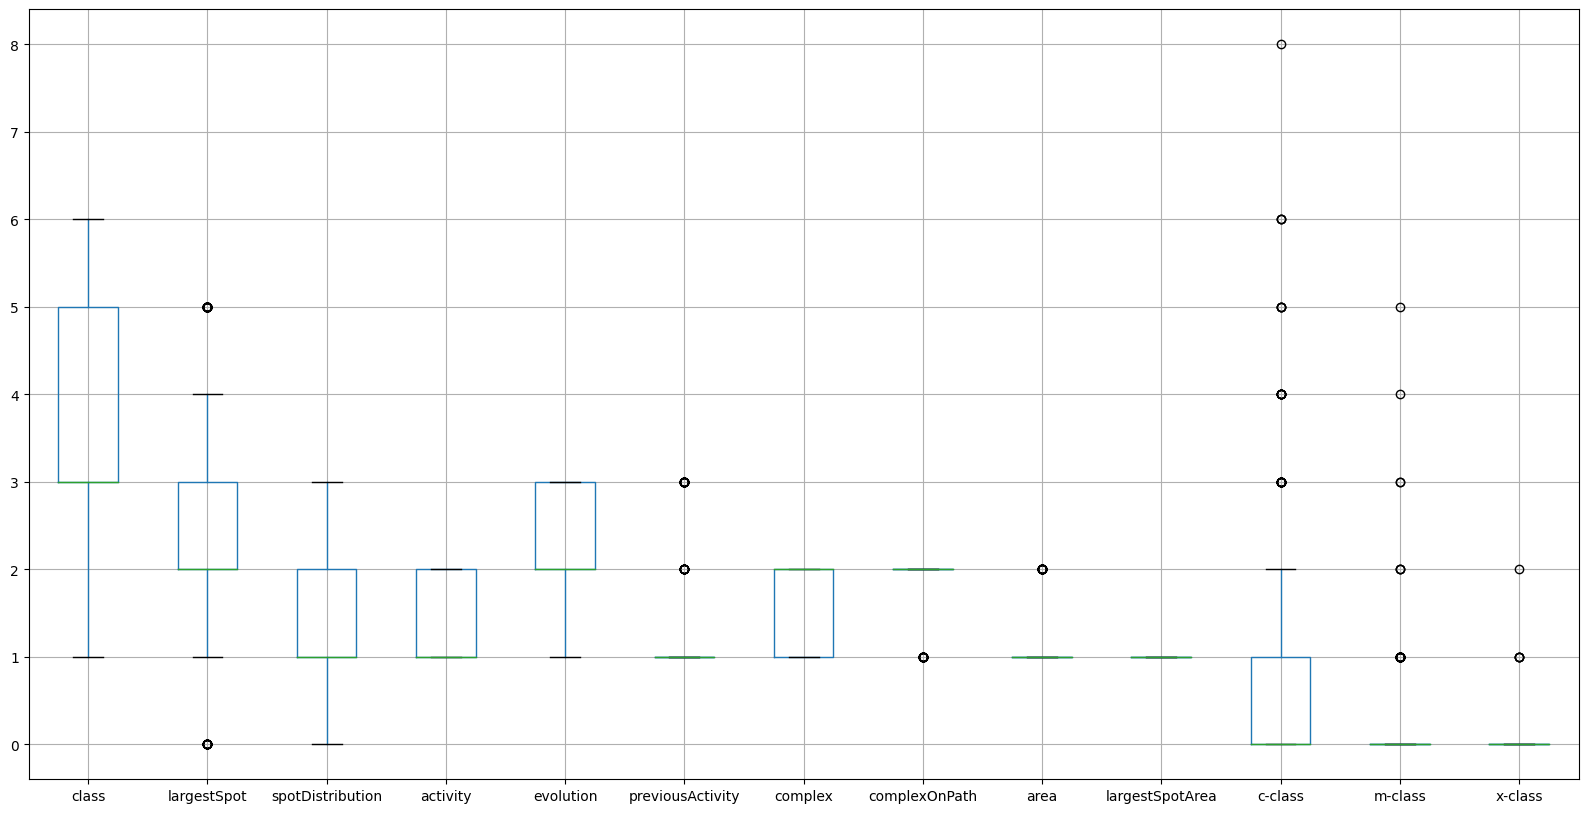

In [8]:
df.boxplot(figsize=(20, 10))

Now because the standard deviation of largestSpotArea is 0 we will drop it because it adds no significance to the dataset

In [9]:
df.drop(['largestSpotArea'] , axis=1, inplace=True)

In [10]:
df.head()

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,c-class,m-class,x-class
0,6,3,0,1,3,1,1,1,1,0,0,0
1,3,1,1,1,3,1,1,2,1,0,0,0
2,2,2,1,1,3,1,1,2,1,0,0,0
3,6,1,0,1,2,1,1,1,1,0,0,0
4,6,2,0,1,1,1,1,2,1,0,0,0


We will first do correlation analysis of X-Class flares using the corr() method which computes pairwise correlation of columns, excluding NA/null values. Using the Pearson method

In [11]:
# Correlation report for x-class flares
x_class = df.drop(["c-class", "m-class"], axis=1)
x_class.corr('pearson', numeric_only=True)

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,x-class
class,1.000000,0.295346,-0.320178,-0.024874,-0.031989,-0.014424,0.097625,-0.433039,0.138077,0.029347
largestSpot,0.295346,1.000000,0.354685,0.206338,0.175642,0.189187,0.291420,0.015654,0.440755,0.187348
spotDistribution,-0.320178,0.354685,1.000000,0.331218,0.189662,0.164613,0.314678,0.427192,0.382278,0.187789
activity,-0.024874,0.206338,0.331218,1.000000,0.053519,0.377204,0.230195,0.153669,0.179668,0.109683
evolution,-0.031989,0.175642,0.189662,0.053519,1.000000,-0.005575,-0.130782,-0.015768,0.126111,0.049666
previousActivity,-0.014424,0.189187,0.164613,0.377204,-0.005575,1.000000,0.152275,0.084104,0.206888,0.108226
complex,0.097625,0.291420,0.314678,0.230195,-0.130782,0.152275,1.000000,0.177192,0.213896,0.088131
complexOnPath,-0.433039,0.015654,0.427192,0.153669,-0.015768,0.084104,0.177192,1.000000,0.071938,0.029640
area,0.138077,0.440755,0.382278,0.179668,0.126111,0.206888,0.213896,0.071938,1.000000,0.338304
x-class,0.029347,0.187348,0.187789,0.109683,0.049666,0.108226,0.088131,0.029640,0.338304,1.000000


Now running full correlation analysis on all classes

In [12]:
df.corr('pearson', numeric_only=True)

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,c-class,m-class,x-class
class,1.000000,0.295346,-0.320178,-0.024874,-0.031989,-0.014424,0.097625,-0.433039,0.138077,0.008289,-0.024666,0.029347
largestSpot,0.295346,1.000000,0.354685,0.206338,0.175642,0.189187,0.291420,0.015654,0.440755,0.192622,0.144774,0.187348
spotDistribution,-0.320178,0.354685,1.000000,0.331218,0.189662,0.164613,0.314678,0.427192,0.382278,0.237394,0.180689,0.187789
activity,-0.024874,0.206338,0.331218,1.000000,0.053519,0.377204,0.230195,0.153669,0.179668,0.116492,0.041425,0.109683
evolution,-0.031989,0.175642,0.189662,0.053519,1.000000,-0.005575,-0.130782,-0.015768,0.126111,0.100831,0.125060,0.049666
previousActivity,-0.014424,0.189187,0.164613,0.377204,-0.005575,1.000000,0.152275,0.084104,0.206888,0.073546,0.096034,0.108226
complex,0.097625,0.291420,0.314678,0.230195,-0.130782,0.152275,1.000000,0.177192,0.213896,0.065274,0.060829,0.088131
complexOnPath,-0.433039,0.015654,0.427192,0.153669,-0.015768,0.084104,0.177192,1.000000,0.071938,0.110985,0.047554,0.029640
area,0.138077,0.440755,0.382278,0.179668,0.126111,0.206888,0.213896,0.071938,1.000000,0.083061,0.231828,0.338304
c-class,0.008289,0.192622,0.237394,0.116492,0.100831,0.073546,0.065274,0.110985,0.083061,1.000000,0.077413,-0.009669
